# Visualization Demo

In [12]:
from brainlit.utils.session import NeuroglancerSession
#from brainlit.utils.swc import *
from brainlit.viz.visualize import *
import numpy as np
from skimage import io
from pathlib import Path
import napari
from napari.utils import nbscreenshot
%gui qt5

## Loading Data

In [6]:
themip = 0
sid = 2
vid = 300

In [7]:
# Create a neuroglancersession
ngl_sess = NeuroglancerSession(
    url="s3://open-neurodata/brainlit/brain1", 
    url_segments="s3://open-neurodata/brainlit/brain1_segments",
    mip=themip
)

In [18]:
img, bbbox, vox = ngl_sess.pull_voxel(sid, vid, 25)

Downloading:   0%|          | 0/4 [00:00<?, ?it/s]


In [19]:
skel = ngl_sess.cv_segments.skeleton.get(sid)
vertex = skel.vertices[vid]/ngl_sess.cv_segments.scales[themip]["resolution"]
print(vertex)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s][15220.96557495  4910.96024443  6446.54367517]



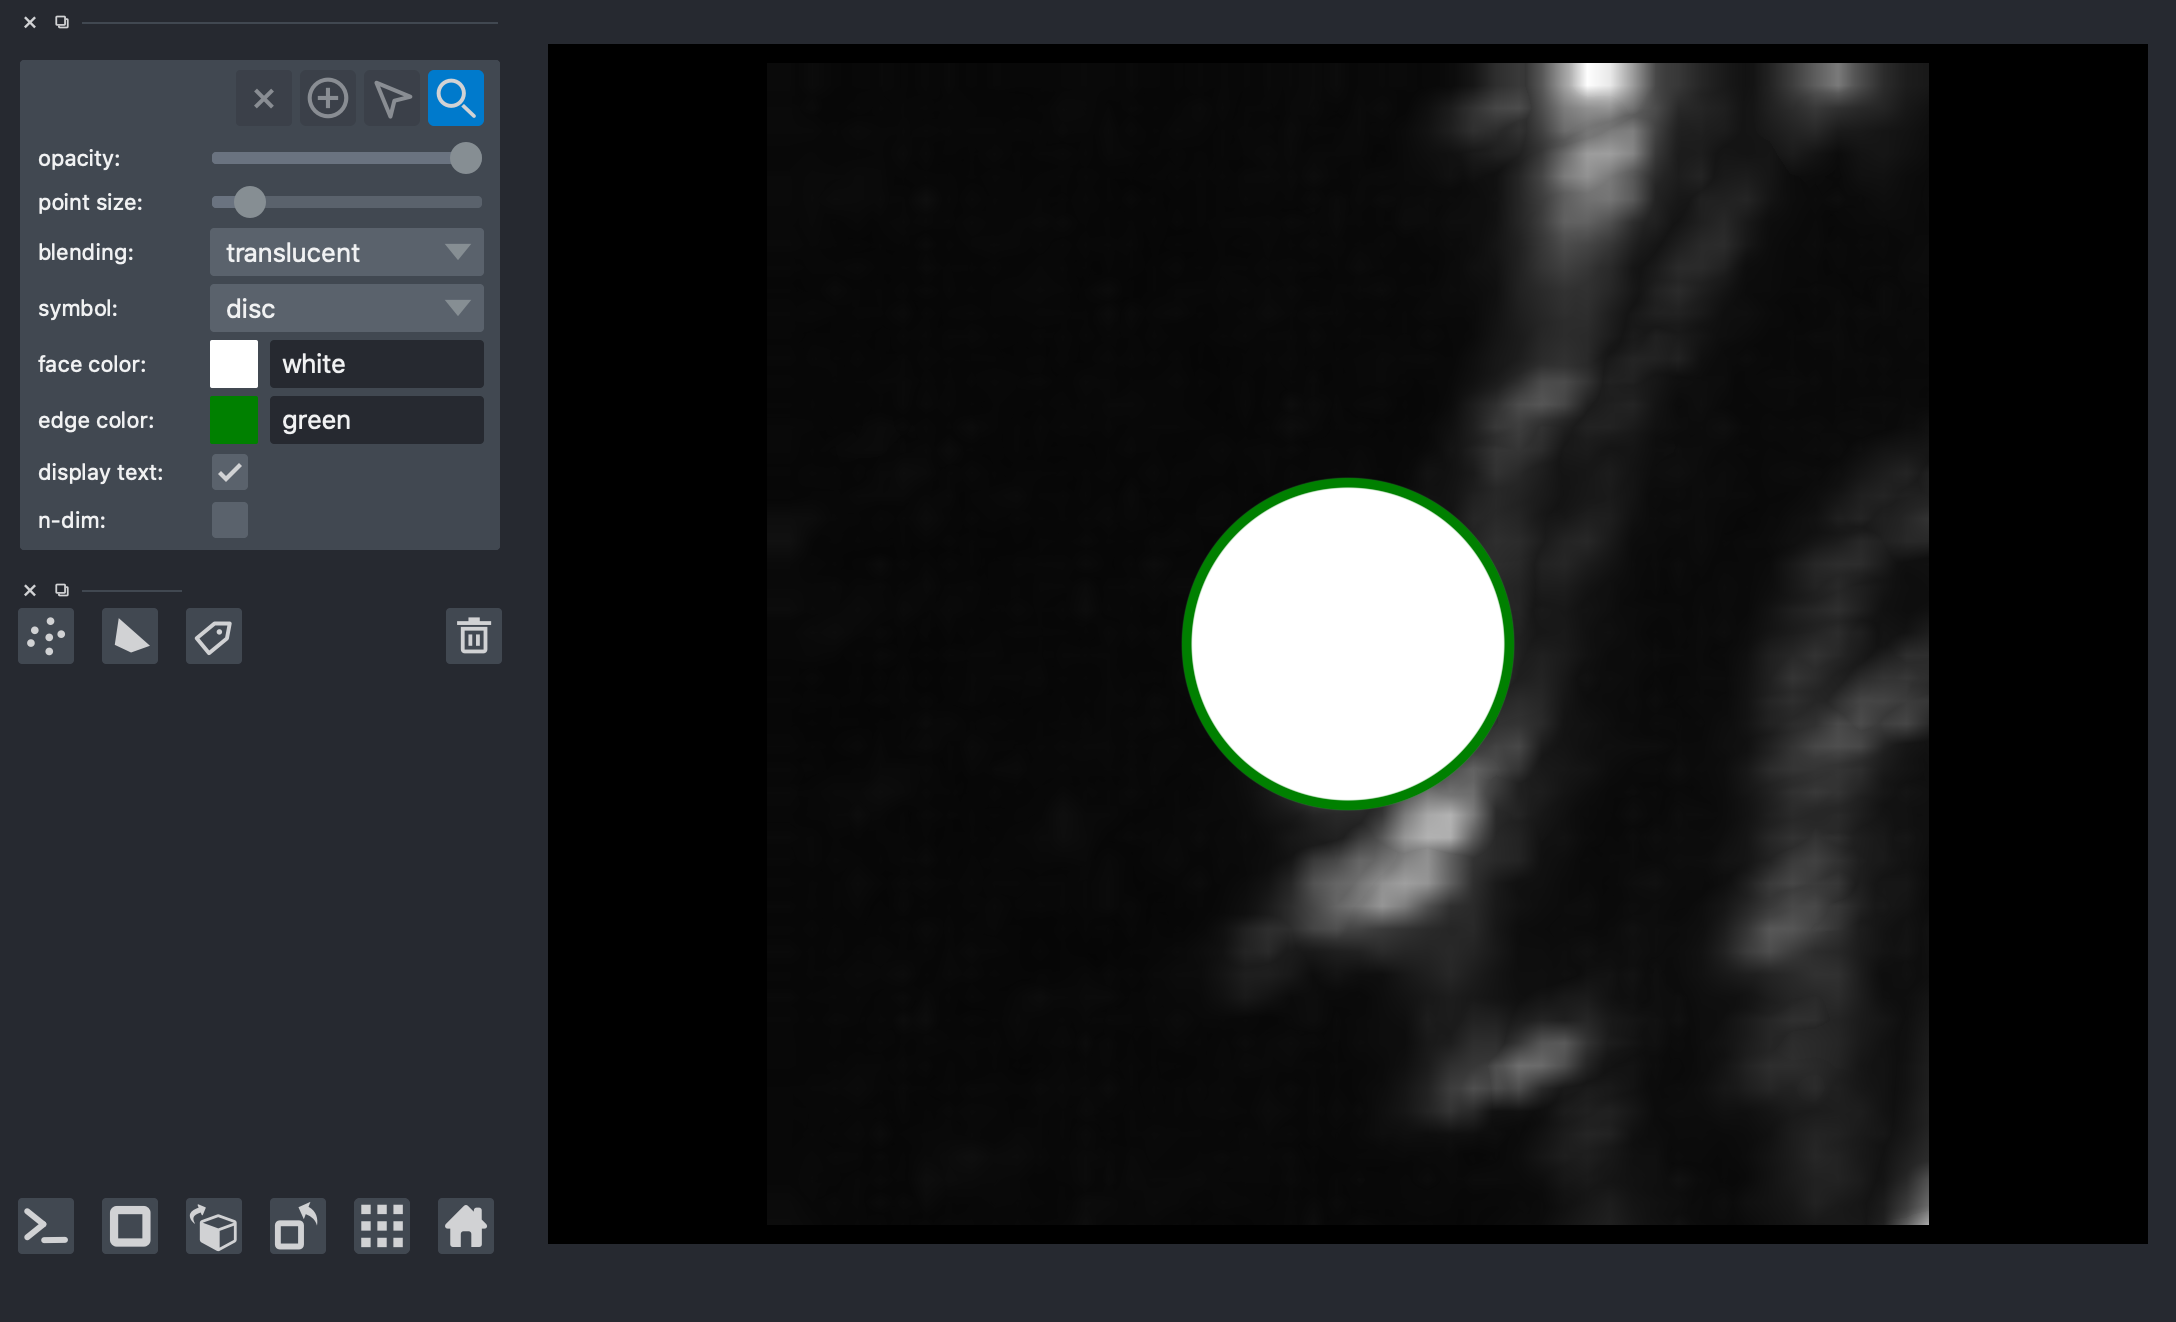

In [23]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(np.array(img)))
viewer.add_points(data=np.array(vox), edge_width=5, edge_color='green', name='vertex')
nbscreenshot(viewer)

## Max intensity projection

<class 'matplotlib.figure.Figure'>


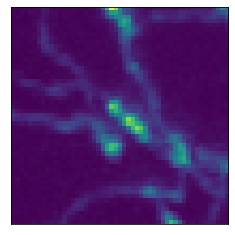

In [25]:
fig, axis = plot_image_mip(img)
print(type(fig))

## Histogram Plot of Image Intensities

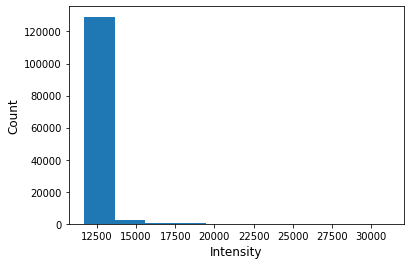

In [26]:
fig = plot_image_hist(img)

## Visualizing all successors or predecessors of a given vertex up to a given depth

In [27]:
s3_path = "s3://open-neurodata/brainlit/brain1_segments"
seg_id = 2
df = read_s3(s3_path, seg_id, mip=themip)
df.head()

NameError: name 'read_s3' is not defined

In [ ]:
G = df_to_graph(df)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('\n')
print('Sample 1 coordinates (x,y,z)')
print(G.nodes[1]['x'],G.nodes[1]['y'],G.nodes[1]['z'])

paths = graph_to_paths(G=G)
print(f"The graph was decomposed into {len(paths)} paths")

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(np.array(img)))
# viewer.add_points(data=np.concatenate(paths, axis=0)[1024:], edge_width=2, edge_color='white', name='all_points')
viewer.add_shapes(data=paths, shape_type='path', edge_color='white', edge_width=3, name='skeleton')
viewer.add_points(data=np.array(vertex), edge_width=5, edge_color='green', name='vertex')
nbscreenshot(viewer)

In [ ]:
v_id = 44  # the row index/number of the data frame
depth = 30  # the depth up to which the graph must be constructed

G_bfs=get_bfs_subgraph(G, v_id, depth, df=df)  # perform Breadth first search to obtain a graph of interest
paths_bfs = graph_to_paths(G=G_bfs[0])  # obtain all the paths for visualization purposes

In [ ]:
x = df.iloc[v_id]['x']
y = df.iloc[v_id]['y']
z = df.iloc[v_id]['z']
v_pos = np.array([x,y,z])

# display vertex
viewer = napari.Viewer(ndisplay=3)
viewer.add_points(data=v_pos, edge_width=20, edge_color='orange', name='vertex')

# display all interest nodes around vertex
viewer.add_points(data=np.concatenate(paths_bfs), edge_color='red', edge_width=2, name='subpoints')
viewer.add_shapes(data=paths_bfs, shape_type='path', edge_color='red', edge_width=3, name='sub-skeleton')